## Import libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import numpy as np
from numpy import polyfit
import warnings
warnings.filterwarnings('ignore')

In [3]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Flatten
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from keras.callbacks import ModelCheckpoint, EarlyStopping

# *****************************************************
## Import And Preprocess Data Set

In [4]:
df = pd.read_csv("/content/drive/My Drive/climate5April/CO2/FinalCo2.csv")
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
# Convert Effective date type to datetime
df["Date"] = pd.to_datetime(df["Date"])

df.head(2)

,Date,Value
0,1959-03-01,316.65
1,1959-04-01,317.72


In [5]:
df=df.loc[df['Date']>='2000-01-01']

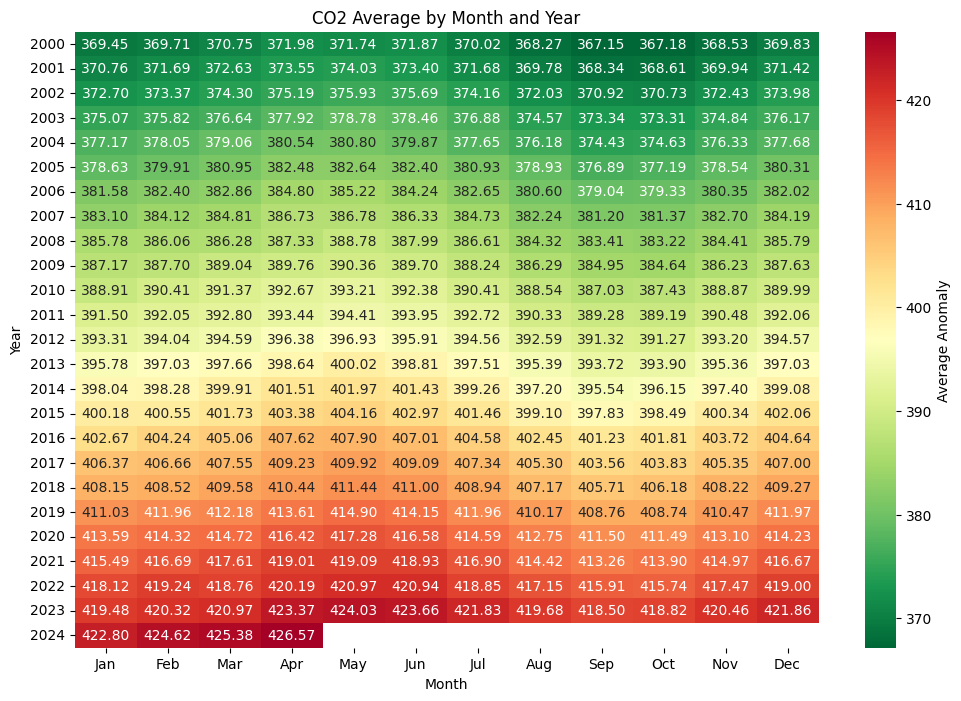

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


df['Date'] = pd.to_datetime(df['Date'])

# Extract year and month from the date
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.strftime('%b')  # Use abbreviated month names

# Pivot the data to have years as rows and months as columns
df_pivot = df.pivot(index='Year', columns='Month', values='Value')

# Ensure months are in correct order
months_order = ["Jan", "Feb", "Mar", "Apr", "May", "Jun",
                "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
df_pivot = df_pivot[months_order]

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df_pivot, annot=True, fmt=".2f", cmap="RdYlGn_r", cbar_kws={'label': 'Average Anomaly'})
plt.title("CO2 Average by Month and Year")
plt.xlabel("Month")
plt.ylabel("Year")
plt.show()


In [6]:
df.set_index('Date', inplace=True)

df.head()

,Value
Date,
2000-01-01,369.45
2000-02-01,369.71
2000-03-01,370.75
2000-04-01,371.98
2000-05-01,371.74


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 292 entries, 2000-01-01 to 2024-04-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Value   292 non-null    float64
dtypes: float64(1)
memory usage: 4.6 KB


In [7]:
train = df[:190]
valid = df[190:250]
test = df[250:]

scaler = MinMaxScaler()

# Fit scaler on training data and transform all subsets
train_data = scaler.fit_transform(train[['Value']])
validate_data = scaler.transform(valid[['Value']])
test_data = scaler.transform(test[['Value']])

print("Train data size:", len(train_data))
print("Validation data size:", len(validate_data))
print("Test data size:", len(test_data))



Train data size: 190
Validation data size: 60
Test data size: 42


In [9]:
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

# Create sequences
seq_length = 1 # You can experiment with this value
X_train, y_train = create_sequences(train_data, seq_length)
X_val, y_val = create_sequences(validate_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

In [9]:
import numpy as np
from keras.models import Model
from keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Bidirectional, LSTM, Dropout, Concatenate
from tensorflow.keras.regularizers import l2
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Define the sequence creation function
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

# Create sequences
seq_length = 5  # You can experiment with this value
X_train, y_train = create_sequences(train_data, seq_length)
X_val, y_val = create_sequences(validate_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

# Reshape for CNN and LSTM
X_train_cnn = X_train.reshape(-1, seq_length, 1)
X_val_cnn = X_val.reshape(-1, seq_length, 1)
X_test_cnn = X_test.reshape(-1, seq_length, 1)

X_train_lstm = X_train.reshape(-1, seq_length, 1)
X_val_lstm = X_val.reshape(-1, seq_length, 1)
X_test_lstm = X_test.reshape(-1, seq_length, 1)

# CNN-LSTM hybrid model
# Input shape for CNN
cnn_input = Input(shape=(seq_length, 1))
x = Conv1D(filters=64, kernel_size=3, activation='relu', kernel_regularizer=l2(0.01))(cnn_input)  # L2 regularization
x = MaxPooling1D(pool_size=2)(x)
x = Flatten()(x)

# LSTM Model
lstm_input = Input(shape=(seq_length, 1))
y = Bidirectional(LSTM(200, return_sequences=True, kernel_regularizer=l2(0.01)))(lstm_input)
y = Dropout(0.5)(y)  # Higher dropout for regularization
y = Bidirectional(LSTM(200, kernel_regularizer=l2(0.01)))(y)
y = Dropout(0.5)(y)
y = Dense(100, activation='relu')(y)

# Combining CNN and LSTM outputs
combined = Concatenate()([x, y])
combined = Dense(100, activation='relu')(combined)
combined = Dense(1)(combined)  # Final output layer

# Create the model
model = Model(inputs=[cnn_input, lstm_input], outputs=combined)

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Summary of the model
model.summary()

# Set up early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    [X_train_cnn, X_train_lstm],
    y_train,
    epochs=100,
    batch_size=32,
    validation_data=([X_val_cnn, X_val_lstm], y_val),
    callbacks=[early_stopping]
)

# Evaluate the model
loss = model.evaluate([X_test_cnn, X_test_lstm], y_test)
print(f'Test Loss: {loss}')


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 5, 1)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_2           │ (None, 5, 400)         │        323,200 │ input_layer_3[0][0]    │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_2             │ (None, 5, 1)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 5, 400)         │              0 │ bidirectional_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_1 (Conv1D)         │ (None, 3, 64)          │            256 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_3           │ (None, 400)            │        961,600 │ dropout_2[0][0]        │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_1           │ (None, 1, 64)          │              0 │ conv1d_1[0][0]         │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 400)            │              0 │ bidirectional_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_1 (Flatten)       │ (None, 64)             │              0 │ max_pooling1d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 100)            │         40,100 │ dropout_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 164)            │              0 │ flatten_1[0][0],       │
│ (Concatenate)             │                        │                │ dense_3[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 100)            │         16,500 │ concatenate_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 1)              │            101 │ dense_4[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,341,757 (5.12 MB)

 Trainable params: 1,341,757 (5.12 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 285ms/step - loss: 10.3763 - val_loss: 8.3270
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 163ms/step - loss: 7.8104 - val_loss: 6.2861
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 155ms/step - loss: 5.8702 - val_loss: 4.7425
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - loss: 4.3382 - val_loss: 3.3979
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - loss: 3.1400 - val_loss: 2.4259
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - loss: 2.2347 - val_loss: 1.7205
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 1.5659 - val_loss: 1.1843
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - loss: 1.0789 - val_loss: 0.8064
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 0.7317 - val_loss: 0.5526
Epoch 10/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 0.4904 - val_loss: 0.3642
Epoch 11/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - loss: 0.3244 - val_loss: 0.2482
Epoch 12/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 0.2124 - 

In [9]:

X_train_cnn = X_train.reshape(-1, seq_length, 1)  # For CNN
X_val_cnn = X_val.reshape(-1, seq_length, 1)      # For validation

X_train_lstm = X_train.reshape(-1, seq_length, 1)  # For LSTM
X_val_lstm = X_val.reshape(-1, seq_length, 1)      # For validation

train_predict = model.predict([X_train_cnn, X_train_lstm])
Test_predict = model.predict([X_val_cnn, X_val_lstm])

train_predict = train_predict.reshape(-1)
Test_predict = Test_predict.reshape(-1)


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 313ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


In [11]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from math import sqrt



train_mse = mean_squared_error(y_train, train_predict)
test_mse = mean_squared_error(y_val, Test_predict)

train_rmse = sqrt(train_mse)
Test_rmse = sqrt(test_mse)

train_mae = mean_absolute_error(y_train, train_predict)
Test_mae = mean_absolute_error(y_val, Test_predict)

train_r2 = r2_score(y_train, train_predict)
Test_r2 = r2_score(y_val, Test_predict)

print(f"Train MSE: {train_mse:.4f}")
print(f"Test MSE: {Test_mse:.4f}")

print(f"Train RMSE: {train_rmse:.4f}")
print(f"Test RMSE: {Test_rmse:.4f}")

print(f"Train MAE: {train_mae:.4f}")
print(f"Test MAE: {Test_mae:.4f}")

print(f"Train R²: {train_r2:.4f}")
print(f"test R²: {Test_r2:.4f}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Train MSE: 0.0071
Test MSE: 0.0120
Train RMSE: 0.0840
Test RMSE: 0.1094
Train MAE: 0.0720
Test MAE: 0.0952
Train R²: 0.8931
test R²: -0.1088


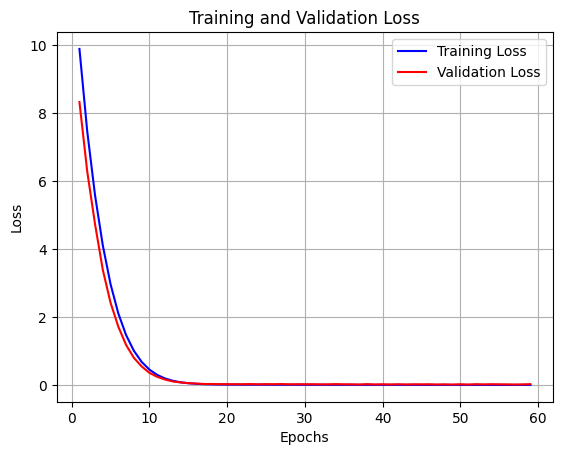

In [11]:
import matplotlib.pyplot as plt

def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(1, len(loss) + 1)

    plt.plot(epochs, loss, "b-", label="Training Loss")
    plt.plot(epochs, val_loss, "r-", label="Validation Loss")

    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid()
    plt.show()

visualize_loss(history, "Training and Validation Loss")


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


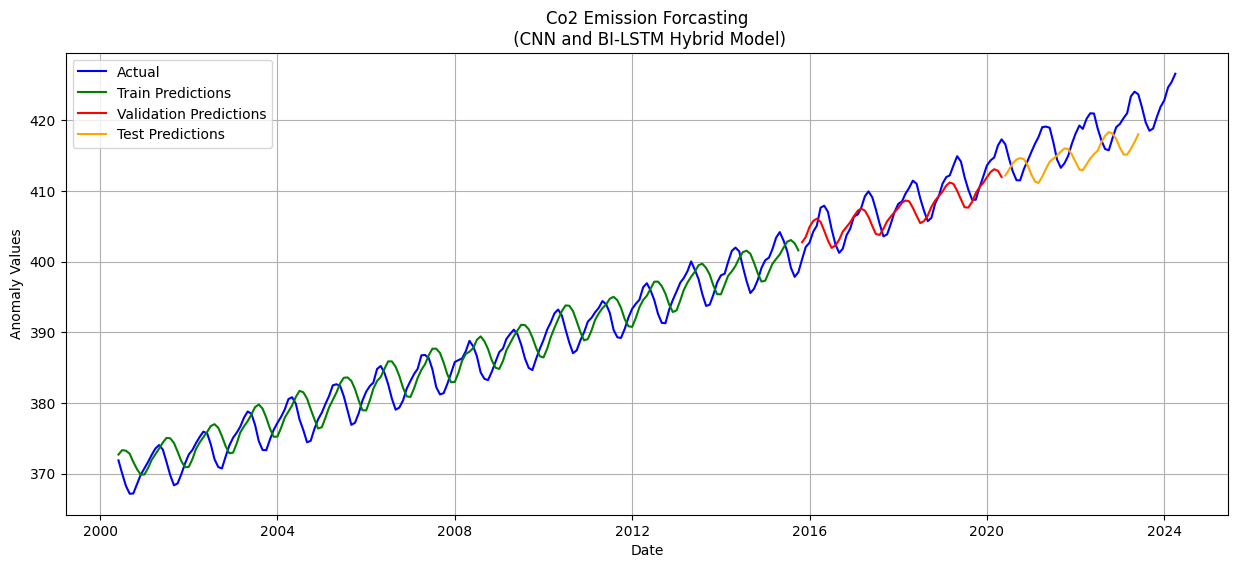

In [ ]:
import matplotlib.pyplot as plt

# Make predictions
train_predictions = model.predict([X_train_cnn, X_train_lstm])
val_predictions = model.predict([X_val_cnn, X_val_lstm])
test_predictions = model.predict([X_test_cnn, X_test_lstm])

# Inverse transform the predictions
train_predictions = scaler.inverse_transform(train_predictions)
val_predictions = scaler.inverse_transform(val_predictions)
test_predictions = scaler.inverse_transform(test_predictions)

# Create a figure for plotting
plt.figure(figsize=(15, 6))

# Plot actual values
plt.plot(df.index[seq_length:], df['Value'][seq_length:], label='Actual', color='blue')

# Plot training predictions
plt.plot(df.index[seq_length:seq_length+len(train_predictions)], train_predictions, label='Train Predictions', color='green')

# Plot validation predictions
val_pred_index = range(seq_length + len(train_predictions), seq_length + len(train_predictions) + len(val_predictions))
plt.plot(df.index[val_pred_index], val_predictions, label='Validation Predictions', color='red')

# Plot test predictions
test_pred_index = range(seq_length + len(train_predictions) + len(val_predictions),
                        seq_length + len(train_predictions) + len(val_predictions) + len(test_predictions))
plt.plot(df.index[test_pred_index], test_predictions, label='Test Predictions', color='orange')

# Configure plot
plt.title('Co2 Emission Forcasting\n (CNN and BI-LSTM Hybrid Model)')
plt.xlabel('Date')
plt.ylabel('Anomaly Values')
plt.legend()
plt.grid()  # Optional
